# Выполнил: Радайкин Артём, ПМ20-4, вариант 16

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.stats import t

## **Индекс обрабатывающего производства по ОКВЭД2 (IP2_CEA_M) от периода T (месяц)**

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Эконометрика /Семестр_6/Данные_1.xlsx')
df.tail(5)

,T,IP2_CEA_M
92,93,155.3
93,94,160.4
94,95,163.2
95,96,190.7
96,97,131.0


## Исходная модель регрессиии

In [3]:
df['T'] = pd.period_range(start='1/1/2014', end='1/1/2022', freq='M')
df = df.set_index(['T'])
# Преобразуем PeriodIndex в DatetimeIndex
df.index = df.index.to_timestamp()

In [4]:
X, Y = df.drop("IP2_CEA_M",axis=1) , df["IP2_CEA_M"] 

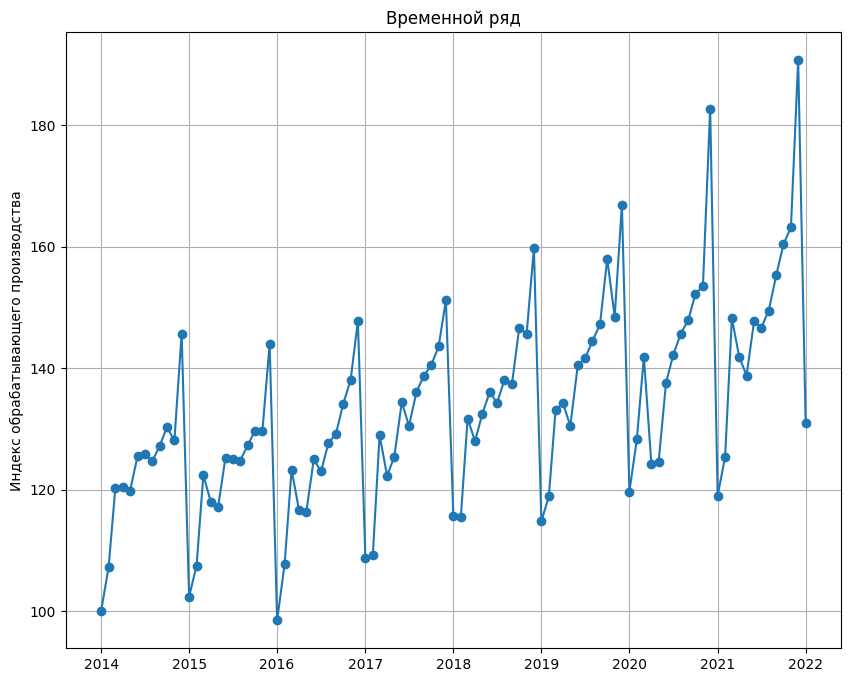

In [5]:
fig, axes = plt.subplots(1,1, figsize=(10, 8))
plt.plot(df.index, Y, axes=axes, marker='o')
plt.title('Временной ряд')
plt.ylabel('Индекс обрабатывающего производства')
plt.grid();

## 1. Выбрать кривую роста. Обосновать выбор.

В моём варианте лучше всего выбрать сезонную кривую роста, т.к. данные во временном ряду имеют выраженную сезонность. Сезонная кривая роста отражает повторяющиеся паттерны в данных, которые связаны с сезонностью (в моём случае ежегодные колебания индекса обрабатывающего производства). 

Как мы видим на графике, присутствует явный восходящий тренд, а также сезонность.

Теперь давайте проверим, есть ли сезонность в данных, используя декомпозицию:

Команда `result.seasonal.plot` отображает только компонент сезонности на графике, причем она сглажена и восстановлена в том же масштабе, что и исходный временной ряд. На графике сезонность представлена в виде кривой, которая показывает, как меняется среднее значение временного ряда в зависимости от времени внутри сезонного цикла.

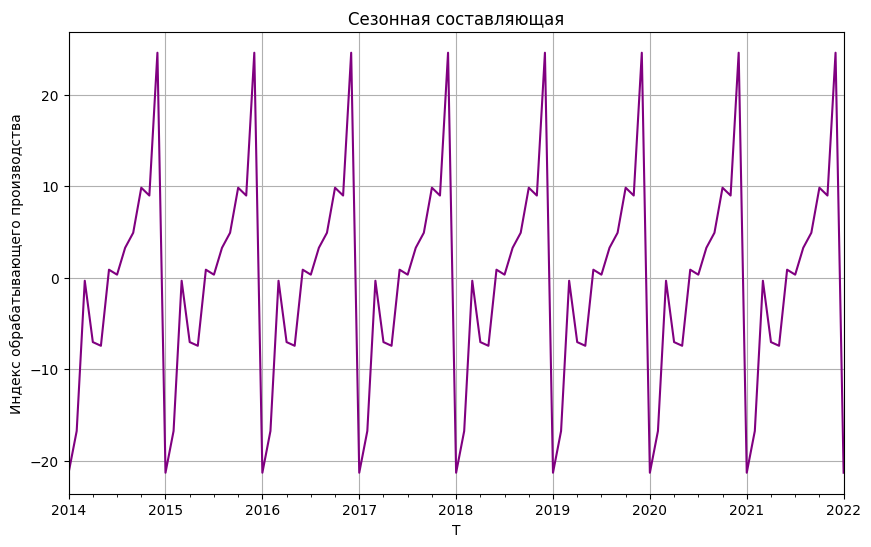

In [6]:
result = seasonal_decompose(df, model='additive')
result.seasonal.plot(figsize=(10,6), color='purple')
plt.title('Сезонная составляющая')
plt.ylabel('Индекс обрабатывающего производства')
plt.grid()
plt.show()

### Вывод: из полученного выше графика видно, что сезонность присутвует.

Мы можем более явно посмотреть на тренд, разложив временной ряд на его составляющие:

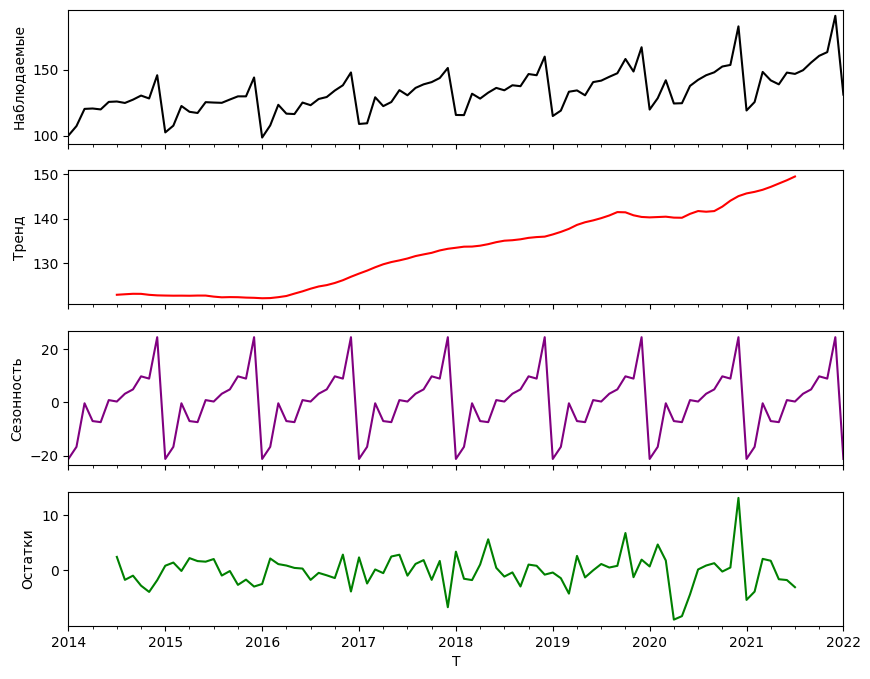

In [7]:
result = seasonal_decompose(df, model='additive')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,8))
result.observed.plot(ax=axes[0], legend=False, color='black')
axes[0].set_ylabel('Наблюдаемые')
result.trend.plot(ax=axes[1], legend=False, color='red')
axes[1].set_ylabel('Тренд')
result.seasonal.plot(ax=axes[2], legend=False, color='purple')
axes[2].set_ylabel('Сезонность')
result.resid.plot(ax=axes[3], legend=False, color='green')
axes[3].set_ylabel('Остатки')
plt.show()


### Вывод: в нашем случае, лучше всего выбрать аддитивную модель, т.к.  изменения в тренде и сезонности в течение времени примерно остаются на одном уровне и имеют небольшую абсолютную величину.

## 2. Провести прогнозирование с помощью кривой роста. Рассчитать точечный и интервальный прогноз на 4 периода вперед. 

### **В данном случа расматриваем модель с аддитивной сезоностью!**

Для прогнозирования временного ряда с помощью сезонной кривой роста можно использовать методы экспоненциального сглаживания, такие как метод Хольта-Винтерса или его модификации.

### Метод Хольта-Винтерса с сезонностью:

Точечный прогноз на 4 периода вперед: [158.17693459 157.56271944 173.40559857 127.65485282]
Доверительный интервал:
            Нижняя граница  Верхняя граница
2021-10-01      105.516261       210.837609
2021-11-01      104.902045       210.223394
2021-12-01      120.744925       226.066273
2022-01-01       74.994179       180.315527


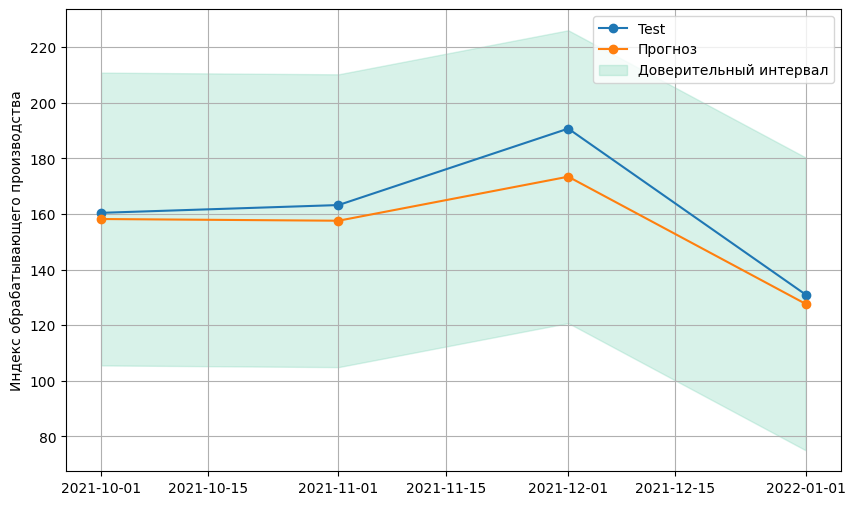

                       ExponentialSmoothing Model Results                       
Dep. Variable:                IP2_CEA_M   No. Observations:                   93
Model:             ExponentialSmoothing   SSE                           1111.025
Optimized:                         True   AIC                            262.681
Trend:                         Additive   BIC                            303.202
Seasonal:                      Additive   AICC                           271.924
Seasonal Periods:                    12   Date:                 Thu, 30 Mar 2023
Box-Cox:                          False   Time:                         12:08:13
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2953929                alpha                 True
smoothing_trend          

In [8]:
# Разделяем на тренировочный и тестовый наборы
train = df[:-4]
test = df[-4:]

# Применяем метод Хольта-Винтерса с сезонностью
model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
fit = model.fit()

# Строим прогноз на 4 периода вперед
forecast = fit.forecast(steps=4)

# Расчет точечного и интервального прогнозов на 4 периода вперед
point_forecast = forecast.values


# Расчет стандартной ошибки прогноза
n_periods = 4
forecast_errors = test[-n_periods:].values - point_forecast
stderr = np.std(forecast_errors)

# Расчет интервального прогноза на 4 периода вперед
z_score = 1.96 # для доверительного интервала в 95%
lower_bounds, upper_bounds = [], []
for i in range(len(point_forecast)):
    lower = point_forecast[i] - (z_score * stderr)
    upper = point_forecast[i] + (z_score * stderr)
    lower_bounds.append(lower)
    upper_bounds.append(upper)

# Выводим результаты
print("Точечный прогноз на 4 периода вперед:", point_forecast)

confidence_interval = pd.DataFrame({'Нижняя граница': lower_bounds, 'Верхняя граница': upper_bounds}, index=forecast.index)
print("Доверительный интервал:")
print(confidence_interval)

# Строим график прогноза и тестового набора
# plt.plot(train.index, train, label='Train')
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Test', marker='o')
plt.plot(forecast.index, forecast, label='Прогноз', marker='o')
plt.fill_between(confidence_interval.index, confidence_interval['Нижняя граница'], confidence_interval['Верхняя граница'], alpha=0.25, label='Доверительный интервал',
                 color='#66CDAA')
plt.ylabel('Индекс обрабатывающего производства')
plt.legend()
plt.grid()
plt.show()
# Выводим уравнение
print(fit.summary())

## 3. Осуществить прогнозирование с применением адаптивной модели прогнозирования Брауна.

### **В данном случа расматриваем модель с аддитивной сезоностью!**

Уравнение адаптивной модели прогнозирования Брауна имеет вид:

Y(t) = L(t-1) + b(t-1) + e(t)

где:
* Y(t) - значение ряда в момент времени t;
* L(t-1) - уровень ряда на момент времени (t-1);
* b(t-1) - тенденция ряда на момент времени (t-1);
* e(t) - случайная ошибка на момент времени t.

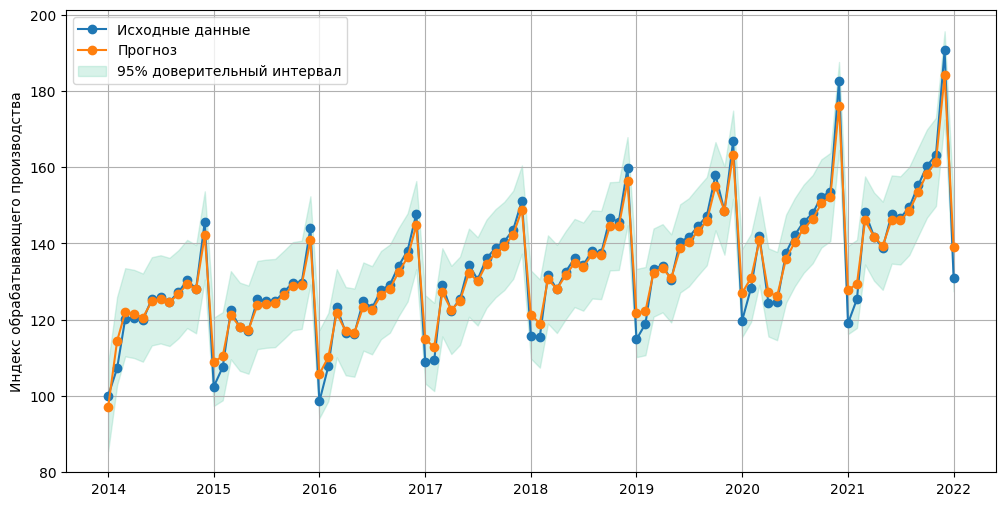

In [9]:
alpha = 0.4
data = df['IP2_CEA_M']

# Построим модель
def brown_single(data, alpha):
    forecast = np.zeros(len(data))
    level = np.zeros(len(data))
    error = np.zeros(len(data))
    level[0] = data[0]
    error[0] = data[1] - data[0]
    for i in range(1, len(data)):
        if i == 1:
            level[i] = data[i]
            error[i] = data[i] - data[i-1]
        else:
            level[i] = alpha * data[i] + (1 - alpha) * level[i-1]
            error[i] = alpha * (data[i] - data[i-1]) + (1 - alpha) * error[i-1]
        forecast[i] = level[i] + error[i]
    return forecast, level, error

# Получим прогноз и уровень доверия
forecast, level, error = brown_single(data, alpha)
forecast[0] = data[0]- 3
sse = np.sum(error**2)
std_error = np.sqrt(sse / (len(data) - 2))
# Вычисляем коэффициент Стьюдента
coeff = t.isf(0.05/2, df.shape[0] - 1) # 95% доверительный интервал

# Построим график прогноза и интервального прогноза
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Исходные данные', marker='o')
plt.plot(data.index, forecast, label='Прогноз', marker='o')
plt.ylabel('Индекс обрабатывающего производства')
plt.grid()
plt.fill_between(data.index, forecast - coeff * std_error, forecast + coeff * std_error, alpha=0.25, label='95% доверительный интервал', color='#66CDAA')
plt.legend();

## 4. Моделирование тренд-сезонных процессов. Применить Модель Хольта-Уинтерса 

### **В данном случа расматриваем модель с аддитивной сезоностью!**

Для модели Хольта-Уинтерса с аддитивной сезонностью:
$$\hat{y}{t+h|t} = l_t + hb + \sum{i=1}^{s}\gamma_{t-m+i},$$
$$l_t = \alpha (y_t - \gamma_{t-s}) + (1 - \alpha)(l_{t-1}+b_{t-1}),$$
$$b_t = \beta(l_t-l_{t-1}) + (1-\beta)b_{t-1},$$
$$\gamma_t = \gamma_{t-s} + \gamma_t^,$$
где $\hat{y}{t+h|t}$ - точечный прогноз на h периодов вперед, $l_t$ - уровень ряда в момент времени t, $b_t$ - уровень тренда в момент времени t, $\gamma_t$ - уровень сезонности в момент времени t, $\alpha$, $\beta$, $\gamma$ - параметры модели, $y_t$ - наблюдаемое значение временного ряда в момент времени t, $\gamma{t-s}$ - уровень сезонности в момент времени t-s, $\gamma_t^$ - ошибка модели сезонности в момент времени t

                       ExponentialSmoothing Model Results                       
Dep. Variable:                IP2_CEA_M   No. Observations:                   97
Model:             ExponentialSmoothing   SSE                           1525.529
Optimized:                         True   AIC                            299.272
Trend:                         Additive   BIC                            340.468
Seasonal:                      Additive   AICC                           308.042
Seasonal Periods:                    12   Date:                 Thu, 30 Mar 2023
Box-Cox:                          False   Time:                         12:08:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1916571                alpha                 True
smoothing_trend          

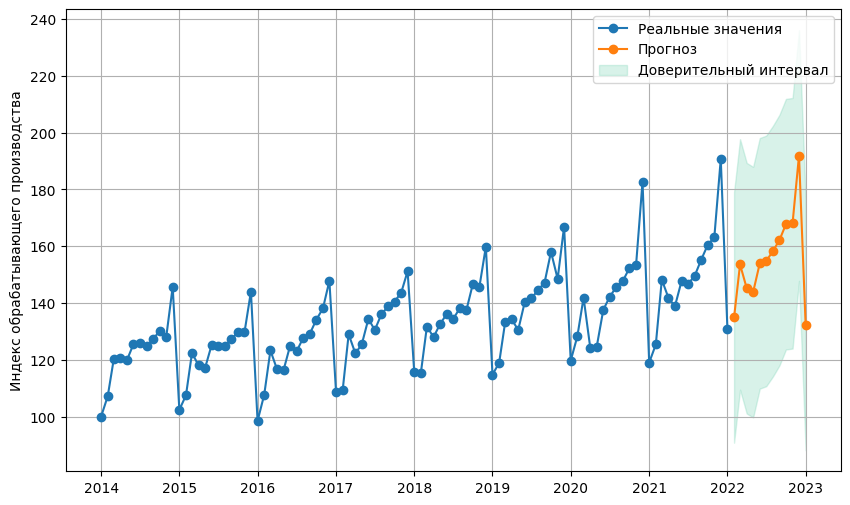

In [10]:
# Строим модель Хольта-Уинтерса
model = ExponentialSmoothing(df, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Строим прогноз на все имеющиеся данные
forecast = fit.forecast(len(df)//8)
# Расчет точечного и интервального прогнозов на 4 периода вперед
point_forecast = forecast.values

forecast_errors = df.values - point_forecast
stderr = np.std(forecast_errors)

# Расчет интервального прогноза на 4 периода вперед
z_score = 1.96 # для доверительного интервала в 95%
lower_bounds, upper_bounds = [], []
for i in range(len(point_forecast)):
    lower = point_forecast[i] - (z_score * stderr)
    upper = point_forecast[i] + (z_score * stderr)
    lower_bounds.append(lower)
    upper_bounds.append(upper)

confidence_interval = pd.DataFrame({'Нижняя граница': lower_bounds, 'Верхняя граница': upper_bounds}, index=forecast.index)

# Выводим уравнение
print(fit.summary())
print(fit.params)

# Строим график прогноза и тестового набора
plt.figure(figsize=(10,6))
plt.plot(df.index, df, label='Реальные значения', marker='o')
plt.plot(forecast.index, forecast, label='Прогноз', marker='o')
plt.fill_between(confidence_interval.index, confidence_interval['Нижняя граница'], confidence_interval['Верхняя граница'], alpha=0.25, label='Доверительный интервал',
                 color='#66CDAA')
plt.ylabel('Индекс обрабатывающего производства')
plt.legend()
plt.grid()
plt.show()

### Вывод: Из всех построенных моделей, **модель Хольта-Уинтерса с аддитивной сезонностью** лучше всего подходит к нашим данным

## 5. Выделение компонент тренд-сезонного временного ряда. Метод Четверикова: По заданным значениям временного ряда y_t выделить компоненты временного ряда: тренд f_t, сезонную компоненту S_t и остаточную последовательность ε_t. 
Построить следующие диаграммы: 
1. Исходный ряд, тренды: предварительный, первый и второй. 
2. Сезонную волну: первую и вторую. 
3. Остаточную компоненту.

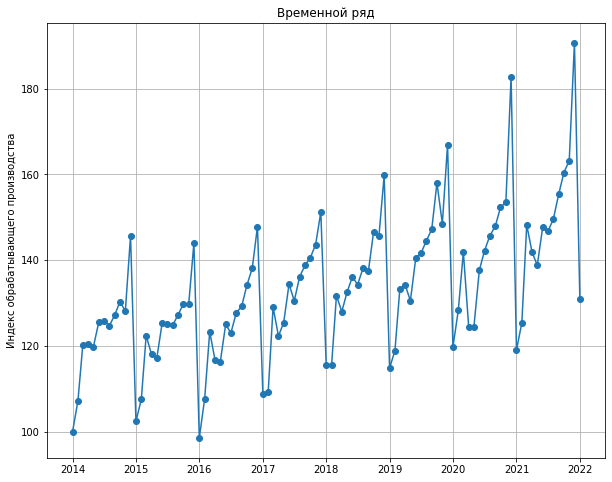

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10, 8))
plt.plot(df.index, Y, axes=axes, marker='o')
plt.title('Временной ряд')
plt.ylabel('Индекс обрабатывающего производства')
plt.grid();

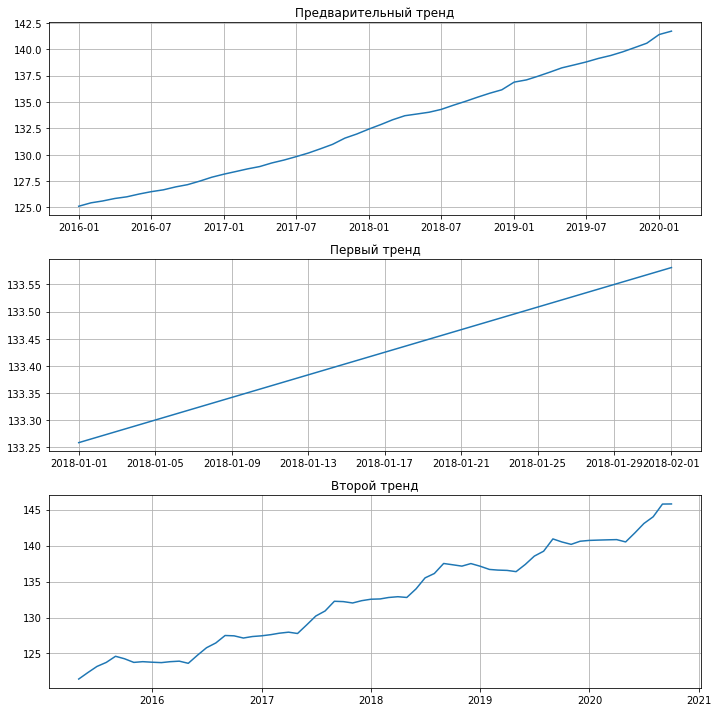

In [ ]:
# Предварительный тренд
preliminary_trend = df.rolling(window=len(df)//2, center=True).mean()

# Первый тренд
first_trend = df.rolling(window=96, center=True).mean()

# Второй тренд
second_trend = df.rolling(window=len(df)//3, center=True).mean()

# Построение графиков
fig, axes = plt.subplots(nrows=3, figsize=(10,10))

axes[0].set_title('Предварительный тренд')
axes[0].plot(preliminary_trend)
axes[0].grid();

axes[1].set_title('Первый тренд')
axes[1].plot(first_trend)
axes[1].grid();

axes[2].set_title('Второй тренд')
axes[2].plot(second_trend)
axes[2].grid();


plt.tight_layout()
plt.show()

### Вывод: несложно заметить, что пристутвует восходящий тренд


Сезонную волну: первую и вторую.

Первая сезонная волна представляет собой колебания в среднем значении ряда в каждом сезоне. Например, если мы имеем дело с временным рядом, отображающим продажи продуктов питания по месяцам, то первая сезонная волна будет показывать, как средние продажи меняются каждый месяц.

Вторая сезонная волна показывает изменения амплитуды колебаний в каждом сезоне. Она может помочь определить, как сильно колебания в данных изменяются в разные сезоны.

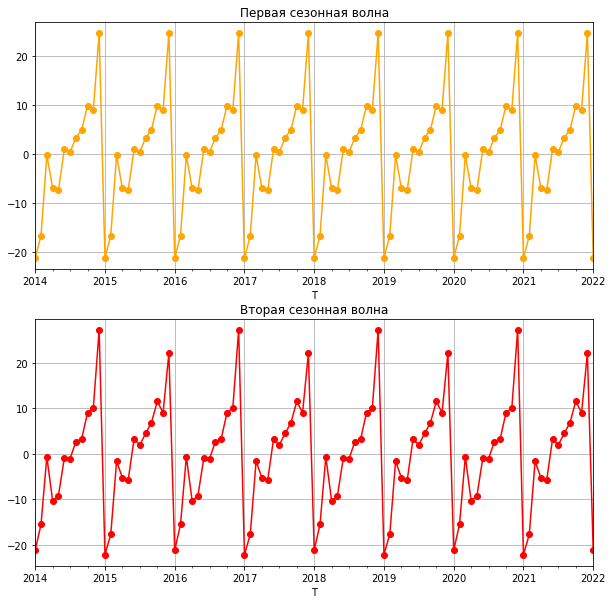

In [ ]:
# Построение графиков
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

# Разложение на сезонную, трендовую и остаточную составляющие
decomposition = seasonal_decompose(df, model='additive', period=12)

# Построение первой сезонной волны
axes[0].set_title('Первая сезонная волна')
decomposition.seasonal.plot(ax=axes[0], color='orange', marker='o')
axes[0].grid();

# Построение второй сезонной волны
decomposition = seasonal_decompose(df, model='additive', period=12*2)
axes[1].set_title('Вторая сезонная волна')
decomposition.seasonal.plot(ax=axes[1], color='red', marker='o')
axes[1].grid();

3. Остаточную компоненту.

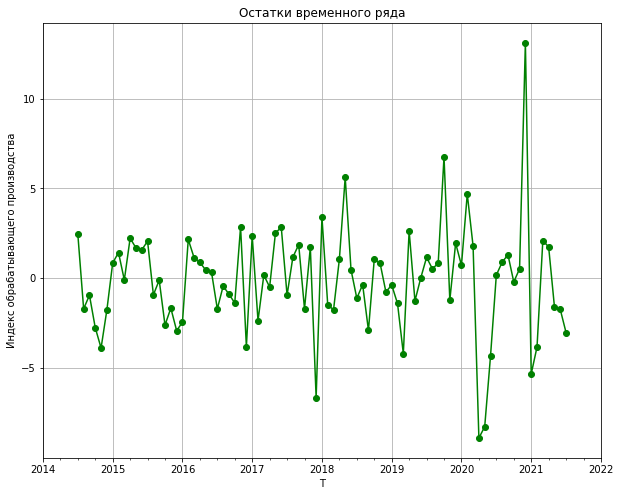

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10, 8))
plt.title('Остатки временного ряда')
result.resid.plot(marker='o', color='green')
plt.ylabel('Индекс обрабатывающего производства')
plt.grid();

### Вывод: можно выделить 2 аномалии: 03.2020 (возможно из-за локдауна всвязи с коронавирусной инфекцией COVID-19) и 12.2020  

In [ ]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/Эконометрика /Семестр_6/ДЗ_23.03.23.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Эконометрика /Семестр_6/ДЗ_23.03.23.ipynb to html
[NbConvertApp] Writing 1251929 bytes to /content/drive/MyDrive/Colab Notebooks/Эконометрика /Семестр_6/ДЗ_23.03.23.html
